### Data Preprocessing
- import the splitted train,test data
- Apply scaling to numeric features.
- Handle categorical features.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# data pre-processing imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## load splitted data

In [4]:
strat_train_set = pd.read_csv("data/train_set.csv")
strat_test_set = pd.read_csv("data/test_set.csv")

print(strat_train_set.shape, strat_test_set.shape)

(16512, 10) (4128, 10)


In [5]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [6]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


## Handling Missing Values:
- Simple Imputer

In [7]:
imputer = SimpleImputer(strategy="median")

### Drop Categorical Columns

In [8]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [9]:
#filling the missing value
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [11]:
X = imputer.fit_transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

### Column Transforming using OneHotEncoder

In [12]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,INLAND
1,NEAR OCEAN
2,INLAND
3,NEAR OCEAN
4,<1H OCEAN
5,NEAR BAY
6,<1H OCEAN
7,<1H OCEAN
8,<1H OCEAN
9,<1H OCEAN


### Observation: 
#### there are only three categories (INLAND,NEAR BAY,<1HOCEAN(CLOSE TO OCEAN))

In [13]:
cat_encoder=OneHotEncoder()
housing_1hot=cat_encoder.fit_transform(housing_cat)
housing_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

### Creating new features:
- Rooms per household
- Population per household
- Latitude-longitude binning

In [15]:

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np  # Added import for np.c_

rooms_ix, bedrooms_ix, population_ix, households_ix = 4, 5, 6, 7

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Fixed indexing: Use X[:, index] instead of X[:index]
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        # Fixed variable name: populatuion_ix → population_ix and households → households_ix
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Fixed variable names: rooms_per_household and population_per_household
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            # Fixed variable names: rooms_per_household and population_per_household
            return np.c_[X, rooms_per_household, population_per_household]
            
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Dropping Features

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# --- Custom FeatureDropper ---
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_indices=None):
        self.drop_indices = drop_indices if drop_indices is not None else []

    def fit(self, X, y=None):
        return self  # Nothing to fit

    def transform(self, X):
        import numpy as np
        return np.delete(X, self.drop_indices, axis=1)

# --- Your pipeline ---
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),   # your custom feature adder
    ('std_scaler', StandardScaler()),
    ('drop', FeatureDropper(drop_indices=[11, 13, 14, 15])),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print(housing_num_tr.shape)  # check reduced feature count

In [108]:
temp_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

X_temp = temp_pipeline.fit_transform(housing_num)
print("Shape after preprocessing:", X_temp.shape)  # (rows, cols)


Shape after preprocessing: (16512, 11)


### Numerical pipeline

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [90]:
num_pipeline

,steps,"[('imputer', ...), ('attribs_adder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,add_bedrooms_per_room,True


In [92]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


### full Pre-processing Pipeline

In [110]:
from sklearn.compose import ColumnTransformer

num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]

full_pipeline=ColumnTransformer([
    ("nums",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(),cat_attribs),
])
housing_prepared=full_pipeline.fit_transform(housing)

In [111]:
housing_prepared.shape

(16512, 16)

### extracting some data for testing 

In [18]:
# some prepared data to test
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]

some_prepared_data=full_pipeline.transform(some_data)

In [19]:
# Separate features and labels
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Apply the pipeline to test features
X_test_prepared = full_pipeline.transform(X_test)

### model: Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### printing result

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_predictions = lin_reg.predict(X_test_prepared)

lin_reg_mse = mean_squared_error(y_test, test_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)
lin_reg_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {lin_reg_rmse:.2f}")
print(f"Test R-squared: {lin_reg_r2:.2f}")

Test RMSE: 67381.26
Test R-squared: 0.65


## XGBoost Regressor

In [24]:
import xgboost as xgb
from xgboost import XGBRegressor 

In [25]:
model=XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(housing_prepared,housing_labels)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
test_predictions = model.predict(X_test_prepared)

xg_boost_mse = mean_squared_error(y_test, test_predictions)
xg_boost_rmse = np.sqrt(xg_boost_mse)
xg_boost_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {xg_boost_rmse:.2f}")
print(f"Test R-squared: {xg_boost_r2:.2f}")

Test RMSE: 47311.49
Test R-squared: 0.83


### R2 score has increased and the rmse value went down
### but is it correct  or the model is overfitting?
## Cross Validation:

In [28]:
from sklearn.model_selection import KFold, cross_val_score

#  Define the K-fold splits
k_folds = KFold(n_splits=10, shuffle=True, random_state=42)

#  Define the model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror'
)

scores = cross_val_score(model, housing_prepared,housing_labels, cv=k_folds, scoring='neg_mean_squared_error')

# 4. Calculate the average and standard deviation of the scores
rmse_scores = np.sqrt(-scores)
print(f"RMSE scores for each fold: {np.round(rmse_scores, 2)}")
print(f"Average RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

RMSE scores for each fold: [44783.9  52016.76 50663.38 48912.48 47247.33 50877.   50105.03 52099.79
 47291.9  48061.83]
Average RMSE: 49205.94
Standard Deviation of RMSE: 2246.09


### trying XGBoost CV function

In [29]:
import xgboost as xgb
dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)
params={
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate":0.1,
    "max_depth":5,
}
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=2000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      108104.237783      257.925066   108248.444774    1052.915713
1      101418.787620      276.588761   101669.793774    1052.220920
2       95533.209964      232.506629    95915.278501    1079.409251
3       90348.366279      246.816106    90853.993701    1118.129125
4       85842.377717      223.743535    86472.665485    1152.478860
..               ...             ...             ...            ...
967     18952.565897      192.884037    47022.406307    1247.048588
968     18936.942402      198.157440    47018.780156    1246.089858
969     18923.595032      195.027267    47021.272567    1244.254950
970     18909.827935      196.384709    47019.142013    1243.592397
971     18897.589011      199.682651    47016.544901    1243.258508

[972 rows x 4 columns]
Best CV RMSE: 47016.54490138988
Best boosting round: 971


### train rmse: 18897 and test rmse: 47016
#### difference between train and test RMSE is approx 30k which means ,the model is still Overfitting. 

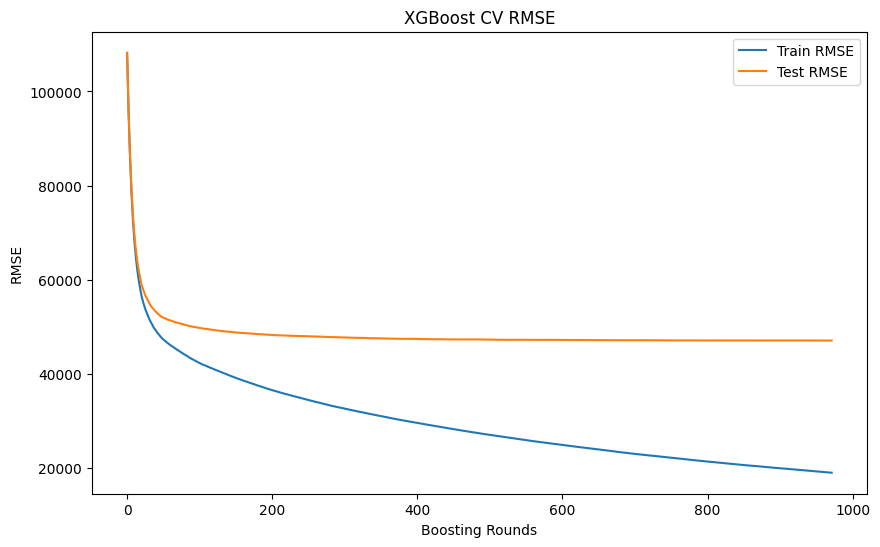

<Figure size 640x480 with 0 Axes>

In [33]:
results = cv_results  # your DataFrame
results[['train-rmse-mean','test-rmse-mean']].plot(figsize=(10,6)) #type: ignore
plt.title("XGBoost CV RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend(["Train RMSE", "Test RMSE"])
plt.show()
plt.savefig("XGBoost.png")

### XGBoost hyper parameters tunning by optuna 
### Minimizing RMSE

In [39]:
import optuna
from sklearn.metrics import r2_score
def objective(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'n_estimators': trial.suggest_int('n_estimators', 100,1500),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight',1,5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'random_state': 42,
    
    }
    #passing the params for optuna
    optuna_model=XGBRegressor(**params)
    optuna_model.fit(housing_prepared,housing_labels)

    y_pred=optuna_model.predict(X_test_prepared)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    #return the evaluation metrics
    return rmse

#create study & optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,show_progress_bar=True)

[I 2025-09-04 18:51:25,096] A new study created in memory with name: no-name-39403ce0-7c03-4299-ab7d-d33a9511a165
Best trial: 0. Best value: 45639.8:   2%|▏         | 1/50 [00:01<01:18,  1.61s/it]

[I 2025-09-04 18:51:26,708] Trial 0 finished with value: 45639.78811224724 and parameters: {'n_estimators': 445, 'max_depth': 5, 'learning_rate': 0.048656959997203104, 'subsample': 0.8485180690558265, 'colsample_bytree': 0.8805507438481899, 'min_child_weight': 2.4951326332463926, 'reg_alpha': 0.1123246430135999, 'reg_lambda': 4.881444255590315}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:   4%|▍         | 2/50 [00:02<00:43,  1.11it/s]

[I 2025-09-04 18:51:27,118] Trial 1 finished with value: 49685.704809649025 and parameters: {'n_estimators': 130, 'max_depth': 5, 'learning_rate': 0.04208684939575911, 'subsample': 0.7460680051623314, 'colsample_bytree': 0.8058591587177674, 'min_child_weight': 1.5019465984641003, 'reg_alpha': 0.8841513947083729, 'reg_lambda': 2.4528223614522564}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:   6%|▌         | 3/50 [00:04<01:15,  1.60s/it]

[I 2025-09-04 18:51:29,545] Trial 2 finished with value: 49567.17801695623 and parameters: {'n_estimators': 1379, 'max_depth': 3, 'learning_rate': 0.016859826395622144, 'subsample': 0.7600847608069737, 'colsample_bytree': 0.7488327485296926, 'min_child_weight': 2.3063896369281403, 'reg_alpha': 0.7806112410999435, 'reg_lambda': 3.8588934873094183}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:   8%|▊         | 4/50 [00:07<01:38,  2.15s/it]

[I 2025-09-04 18:51:32,536] Trial 3 finished with value: 46008.760187371336 and parameters: {'n_estimators': 1337, 'max_depth': 4, 'learning_rate': 0.036973561894087154, 'subsample': 0.732530129244003, 'colsample_bytree': 0.6626492559763678, 'min_child_weight': 3.553430126687897, 'reg_alpha': 0.06017022123890958, 'reg_lambda': 4.743939529353927}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:  10%|█         | 5/50 [00:09<01:31,  2.04s/it]

[I 2025-09-04 18:51:34,382] Trial 4 finished with value: 48522.366484808816 and parameters: {'n_estimators': 999, 'max_depth': 3, 'learning_rate': 0.03597507971309079, 'subsample': 0.7514497889407354, 'colsample_bytree': 0.6930214560717842, 'min_child_weight': 1.5980235607676234, 'reg_alpha': 0.5430258436678884, 'reg_lambda': 2.248607663496913}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:  12%|█▏        | 6/50 [00:11<01:33,  2.14s/it]

[I 2025-09-04 18:51:36,705] Trial 5 finished with value: 45884.36184739695 and parameters: {'n_estimators': 1031, 'max_depth': 4, 'learning_rate': 0.04244260531928784, 'subsample': 0.8269807274844794, 'colsample_bytree': 0.6257793902245821, 'min_child_weight': 1.641771666071591, 'reg_alpha': 0.6557842583469525, 'reg_lambda': 1.576751962247013}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:  14%|█▍        | 7/50 [00:12<01:13,  1.71s/it]

[I 2025-09-04 18:51:37,552] Trial 6 finished with value: 46688.179889868195 and parameters: {'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.05682215674225997, 'subsample': 0.7136099120879703, 'colsample_bytree': 0.897044590678732, 'min_child_weight': 2.956882468831855, 'reg_alpha': 0.5850369458541625, 'reg_lambda': 2.8818768484748714}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:  16%|█▌        | 8/50 [00:14<01:10,  1.67s/it]

[I 2025-09-04 18:51:39,133] Trial 7 finished with value: 46527.62617327677 and parameters: {'n_estimators': 697, 'max_depth': 4, 'learning_rate': 0.05465196811181355, 'subsample': 0.7994466611546606, 'colsample_bytree': 0.620499799467336, 'min_child_weight': 4.654079639749546, 'reg_alpha': 0.7108878788871826, 'reg_lambda': 3.9221044481055607}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:  18%|█▊        | 9/50 [00:15<01:10,  1.72s/it]

[I 2025-09-04 18:51:40,962] Trial 8 finished with value: 48040.20912825728 and parameters: {'n_estimators': 774, 'max_depth': 4, 'learning_rate': 0.021541953474923495, 'subsample': 0.7640366130455148, 'colsample_bytree': 0.6397768443509189, 'min_child_weight': 2.4301921669858126, 'reg_alpha': 0.5963262908781584, 'reg_lambda': 1.9470735949772302}. Best is trial 0 with value: 45639.78811224724.


Best trial: 0. Best value: 45639.8:  20%|██        | 10/50 [00:16<01:00,  1.51s/it]

[I 2025-09-04 18:51:42,008] Trial 9 finished with value: 46962.225975840476 and parameters: {'n_estimators': 372, 'max_depth': 5, 'learning_rate': 0.03128267438240429, 'subsample': 0.822523047760908, 'colsample_bytree': 0.8815327678336777, 'min_child_weight': 3.0256451474962573, 'reg_alpha': 0.15616037937776128, 'reg_lambda': 3.2409932378697563}. Best is trial 0 with value: 45639.78811224724.


Best trial: 10. Best value: 45465.6:  22%|██▏       | 11/50 [00:18<00:56,  1.46s/it]

[I 2025-09-04 18:51:43,335] Trial 10 finished with value: 45465.58522815202 and parameters: {'n_estimators': 495, 'max_depth': 5, 'learning_rate': 0.09559959659143152, 'subsample': 0.8931719340680805, 'colsample_bytree': 0.5332696289985467, 'min_child_weight': 4.792342135774949, 'reg_alpha': 0.3020451825549815, 'reg_lambda': 4.940966520542544}. Best is trial 10 with value: 45465.58522815202.


Best trial: 11. Best value: 45303.7:  24%|██▍       | 12/50 [00:19<00:53,  1.42s/it]

[I 2025-09-04 18:51:44,665] Trial 11 finished with value: 45303.71508707641 and parameters: {'n_estimators': 512, 'max_depth': 5, 'learning_rate': 0.09742061249191969, 'subsample': 0.8900110304117865, 'colsample_bytree': 0.5322048914390023, 'min_child_weight': 4.877779673008167, 'reg_alpha': 0.291469889634026, 'reg_lambda': 4.986454689640456}. Best is trial 11 with value: 45303.71508707641.


Best trial: 12. Best value: 45203.7:  26%|██▌       | 13/50 [00:20<00:52,  1.42s/it]

[I 2025-09-04 18:51:46,091] Trial 12 finished with value: 45203.66155897039 and parameters: {'n_estimators': 558, 'max_depth': 5, 'learning_rate': 0.0935054182935246, 'subsample': 0.8990480502829802, 'colsample_bytree': 0.511228442070238, 'min_child_weight': 4.743609122291566, 'reg_alpha': 0.28695128802433656, 'reg_lambda': 4.182037852994473}. Best is trial 12 with value: 45203.66155897039.


Best trial: 12. Best value: 45203.7:  28%|██▊       | 14/50 [00:22<00:52,  1.45s/it]

[I 2025-09-04 18:51:47,603] Trial 13 finished with value: 45361.471908090825 and parameters: {'n_estimators': 587, 'max_depth': 5, 'learning_rate': 0.09429789303605071, 'subsample': 0.8910113481232735, 'colsample_bytree': 0.5001861657625823, 'min_child_weight': 4.114762959429299, 'reg_alpha': 0.3561278313523748, 'reg_lambda': 4.151199418636105}. Best is trial 12 with value: 45203.66155897039.


Best trial: 14. Best value: 44834.6:  30%|███       | 15/50 [00:24<01:01,  1.76s/it]

[I 2025-09-04 18:51:50,091] Trial 14 finished with value: 44834.644187843856 and parameters: {'n_estimators': 975, 'max_depth': 5, 'learning_rate': 0.07086819522974537, 'subsample': 0.8670367586721756, 'colsample_bytree': 0.5632339941115072, 'min_child_weight': 4.186467740616893, 'reg_alpha': 0.3704642573004425, 'reg_lambda': 4.2762965057740105}. Best is trial 14 with value: 44834.644187843856.


Best trial: 14. Best value: 44834.6:  32%|███▏      | 16/50 [00:26<01:02,  1.82s/it]

[I 2025-09-04 18:51:52,062] Trial 15 finished with value: 45798.41599965427 and parameters: {'n_estimators': 999, 'max_depth': 4, 'learning_rate': 0.07513231052634763, 'subsample': 0.8598478777816547, 'colsample_bytree': 0.5788587727346842, 'min_child_weight': 4.10828325394435, 'reg_alpha': 0.4194164454030526, 'reg_lambda': 3.373850650082512}. Best is trial 14 with value: 44834.644187843856.


Best trial: 14. Best value: 44834.6:  34%|███▍      | 17/50 [00:29<01:05,  1.97s/it]

[I 2025-09-04 18:51:54,379] Trial 16 finished with value: 44857.775788860075 and parameters: {'n_estimators': 880, 'max_depth': 5, 'learning_rate': 0.071092708576451, 'subsample': 0.8644441151536918, 'colsample_bytree': 0.5753001920958944, 'min_child_weight': 4.187552785483469, 'reg_alpha': 0.20857156872213803, 'reg_lambda': 4.294102455047555}. Best is trial 14 with value: 44834.644187843856.


Best trial: 14. Best value: 44834.6:  36%|███▌      | 18/50 [00:31<01:05,  2.04s/it]

[I 2025-09-04 18:51:56,589] Trial 17 finished with value: 51170.18561267923 and parameters: {'n_estimators': 1207, 'max_depth': 3, 'learning_rate': 0.011833418975801974, 'subsample': 0.8622145209261812, 'colsample_bytree': 0.5695702468167374, 'min_child_weight': 4.0415857093381815, 'reg_alpha': 0.19228028997819605, 'reg_lambda': 4.47495546042862}. Best is trial 14 with value: 44834.644187843856.


Best trial: 14. Best value: 44834.6:  38%|███▊      | 19/50 [00:33<01:06,  2.14s/it]

[I 2025-09-04 18:51:58,964] Trial 18 finished with value: 45906.527627742886 and parameters: {'n_estimators': 891, 'max_depth': 4, 'learning_rate': 0.06684353442409491, 'subsample': 0.7885817149125369, 'colsample_bytree': 0.5784167075875796, 'min_child_weight': 3.633195607019434, 'reg_alpha': 0.45230685511443736, 'reg_lambda': 3.5761455870478085}. Best is trial 14 with value: 44834.644187843856.


Best trial: 14. Best value: 44834.6:  40%|████      | 20/50 [00:36<01:12,  2.43s/it]

[I 2025-09-04 18:52:02,064] Trial 19 finished with value: 45168.01730630528 and parameters: {'n_estimators': 1082, 'max_depth': 5, 'learning_rate': 0.026907286269088407, 'subsample': 0.8326498746882676, 'colsample_bytree': 0.7431318682245494, 'min_child_weight': 3.610781077008941, 'reg_alpha': 0.23991689811265632, 'reg_lambda': 1.138009379376096}. Best is trial 14 with value: 44834.644187843856.


Best trial: 20. Best value: 44232.9:  42%|████▏     | 21/50 [00:40<01:17,  2.66s/it]

[I 2025-09-04 18:52:05,251] Trial 20 finished with value: 44232.891755708864 and parameters: {'n_estimators': 1220, 'max_depth': 5, 'learning_rate': 0.06896593285639484, 'subsample': 0.870038170305512, 'colsample_bytree': 0.5948243832654492, 'min_child_weight': 1.0183062716628788, 'reg_alpha': 0.013542758969816715, 'reg_lambda': 4.4196007942300755}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  44%|████▍     | 22/50 [00:42<01:12,  2.58s/it]

[I 2025-09-04 18:52:07,640] Trial 21 finished with value: 45063.2382436309 and parameters: {'n_estimators': 861, 'max_depth': 5, 'learning_rate': 0.07027929564913332, 'subsample': 0.8709546663113311, 'colsample_bytree': 0.5906573626000733, 'min_child_weight': 1.234216061457871, 'reg_alpha': 0.04997670559291295, 'reg_lambda': 4.472854030531808}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  46%|████▌     | 23/50 [00:45<01:13,  2.74s/it]

[I 2025-09-04 18:52:10,749] Trial 22 finished with value: 44403.75696436142 and parameters: {'n_estimators': 1235, 'max_depth': 5, 'learning_rate': 0.07320368407564883, 'subsample': 0.8751231163296099, 'colsample_bytree': 0.5449896564293022, 'min_child_weight': 4.418349449549012, 'reg_alpha': 0.0011699601535599402, 'reg_lambda': 4.396997177205603}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  48%|████▊     | 24/50 [00:48<01:13,  2.81s/it]

[I 2025-09-04 18:52:13,741] Trial 23 finished with value: 44930.23215299744 and parameters: {'n_estimators': 1185, 'max_depth': 5, 'learning_rate': 0.0573184999264718, 'subsample': 0.8765006482487036, 'colsample_bytree': 0.544418985587379, 'min_child_weight': 4.4192160411779655, 'reg_alpha': 0.029889311815016695, 'reg_lambda': 3.606017814194719}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  50%|█████     | 25/50 [00:52<01:15,  3.04s/it]

[I 2025-09-04 18:52:17,308] Trial 24 finished with value: 44783.02601512799 and parameters: {'n_estimators': 1496, 'max_depth': 5, 'learning_rate': 0.07668883371385962, 'subsample': 0.8436935684117736, 'colsample_bytree': 0.6110472172304207, 'min_child_weight': 3.1987044948139562, 'reg_alpha': 0.006505890997883488, 'reg_lambda': 2.968561488231014}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  52%|█████▏    | 26/50 [00:55<01:11,  2.98s/it]

[I 2025-09-04 18:52:20,140] Trial 25 finished with value: 45025.78828651585 and parameters: {'n_estimators': 1434, 'max_depth': 4, 'learning_rate': 0.0815789377094904, 'subsample': 0.848238135346452, 'colsample_bytree': 0.6712591131244163, 'min_child_weight': 2.033515946536424, 'reg_alpha': 0.005462874137737791, 'reg_lambda': 2.859158764241534}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  54%|█████▍    | 27/50 [00:58<01:12,  3.16s/it]

[I 2025-09-04 18:52:23,740] Trial 26 finished with value: 44341.95222819339 and parameters: {'n_estimators': 1477, 'max_depth': 5, 'learning_rate': 0.05980034963230988, 'subsample': 0.8416740564257729, 'colsample_bytree': 0.6057330320891815, 'min_child_weight': 3.0342078945562334, 'reg_alpha': 0.12156328562005461, 'reg_lambda': 2.583477652497612}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  56%|█████▌    | 28/50 [01:01<01:07,  3.09s/it]

[I 2025-09-04 18:52:26,658] Trial 27 finished with value: 44337.9447696635 and parameters: {'n_estimators': 1239, 'max_depth': 5, 'learning_rate': 0.04937946594316349, 'subsample': 0.8086919026719644, 'colsample_bytree': 0.6600563742301886, 'min_child_weight': 1.0035173543250044, 'reg_alpha': 0.12286923990071356, 'reg_lambda': 2.5041251725325875}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  58%|█████▊    | 29/50 [01:04<01:01,  2.91s/it]

[I 2025-09-04 18:52:29,140] Trial 28 finished with value: 45472.466845460636 and parameters: {'n_estimators': 1294, 'max_depth': 4, 'learning_rate': 0.047583966764302765, 'subsample': 0.7833601406800369, 'colsample_bytree': 0.6522620907410065, 'min_child_weight': 1.1450887974716637, 'reg_alpha': 0.10829449632589921, 'reg_lambda': 2.5386721362854354}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  60%|██████    | 30/50 [01:06<00:57,  2.88s/it]

[I 2025-09-04 18:52:31,964] Trial 29 finished with value: 44313.3397138741 and parameters: {'n_estimators': 1151, 'max_depth': 5, 'learning_rate': 0.049055750516180996, 'subsample': 0.8127751340309639, 'colsample_bytree': 0.7264204193118389, 'min_child_weight': 2.0104082917552035, 'reg_alpha': 0.11173431152152705, 'reg_lambda': 2.1678289572239295}. Best is trial 20 with value: 44232.891755708864.


Best trial: 20. Best value: 44232.9:  62%|██████▏   | 31/50 [01:09<00:54,  2.84s/it]

[I 2025-09-04 18:52:34,718] Trial 30 finished with value: 44443.81469492111 and parameters: {'n_estimators': 1136, 'max_depth': 5, 'learning_rate': 0.04779072581531337, 'subsample': 0.8115543747284548, 'colsample_bytree': 0.7415336906449459, 'min_child_weight': 1.0190670886075304, 'reg_alpha': 0.1116702713157795, 'reg_lambda': 1.7892070522415602}. Best is trial 20 with value: 44232.891755708864.


Best trial: 31. Best value: 44136.7:  64%|██████▍   | 32/50 [01:12<00:52,  2.92s/it]

[I 2025-09-04 18:52:37,828] Trial 31 finished with value: 44136.7042324402 and parameters: {'n_estimators': 1302, 'max_depth': 5, 'learning_rate': 0.059555828410594966, 'subsample': 0.8099226288038838, 'colsample_bytree': 0.7136863726823365, 'min_child_weight': 1.8672247937425372, 'reg_alpha': 0.1412316984102931, 'reg_lambda': 2.111412833990051}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  66%|██████▌   | 33/50 [01:15<00:50,  2.97s/it]

[I 2025-09-04 18:52:40,910] Trial 32 finished with value: 44314.75834503369 and parameters: {'n_estimators': 1275, 'max_depth': 5, 'learning_rate': 0.043215035515500516, 'subsample': 0.8122377317541996, 'colsample_bytree': 0.7814668634963811, 'min_child_weight': 1.8462701487012694, 'reg_alpha': 0.16358128267580746, 'reg_lambda': 2.157255352269265}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  68%|██████▊   | 34/50 [01:19<00:50,  3.13s/it]

[I 2025-09-04 18:52:44,412] Trial 33 finished with value: 44474.47007303066 and parameters: {'n_estimators': 1387, 'max_depth': 5, 'learning_rate': 0.03841241869798061, 'subsample': 0.774947594544715, 'colsample_bytree': 0.8106340214562606, 'min_child_weight': 1.9815727818328135, 'reg_alpha': 0.9198484339029, 'reg_lambda': 2.067742524238783}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  70%|███████   | 35/50 [01:22<00:47,  3.16s/it]

[I 2025-09-04 18:52:47,642] Trial 34 finished with value: 44447.81106226383 and parameters: {'n_estimators': 1327, 'max_depth': 5, 'learning_rate': 0.032213590405055836, 'subsample': 0.8123111304054906, 'colsample_bytree': 0.8034218296289034, 'min_child_weight': 1.8518363202001398, 'reg_alpha': 0.17968638367122616, 'reg_lambda': 1.4642772425794441}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  72%|███████▏  | 36/50 [01:25<00:42,  3.04s/it]

[I 2025-09-04 18:52:50,399] Trial 35 finished with value: 44393.38659889456 and parameters: {'n_estimators': 1132, 'max_depth': 5, 'learning_rate': 0.04283425536109631, 'subsample': 0.7977641349430694, 'colsample_bytree': 0.7784175223853171, 'min_child_weight': 1.3898266522525817, 'reg_alpha': 0.08601780028162181, 'reg_lambda': 2.1904472252857334}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  74%|███████▍  | 37/50 [01:27<00:35,  2.71s/it]

[I 2025-09-04 18:52:52,331] Trial 36 finished with value: 47461.32855204492 and parameters: {'n_estimators': 1272, 'max_depth': 3, 'learning_rate': 0.049687002227585285, 'subsample': 0.8190401657290459, 'colsample_bytree': 0.7139163507947646, 'min_child_weight': 2.2130067019831894, 'reg_alpha': 0.8352726428236943, 'reg_lambda': 1.7278335956923447}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  76%|███████▌  | 38/50 [01:30<00:35,  2.92s/it]

[I 2025-09-04 18:52:55,748] Trial 37 finished with value: 44825.34238120069 and parameters: {'n_estimators': 1385, 'max_depth': 5, 'learning_rate': 0.02724078348871785, 'subsample': 0.7340531273815631, 'colsample_bytree': 0.708223917208691, 'min_child_weight': 2.6212262361298633, 'reg_alpha': 0.23316253708903567, 'reg_lambda': 1.3263693350457477}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  78%|███████▊  | 39/50 [01:32<00:29,  2.69s/it]

[I 2025-09-04 18:52:57,908] Trial 38 finished with value: 45418.72431921981 and parameters: {'n_estimators': 1080, 'max_depth': 4, 'learning_rate': 0.04061223357161707, 'subsample': 0.8309575594537886, 'colsample_bytree': 0.840644833828383, 'min_child_weight': 1.7501601987773592, 'reg_alpha': 0.07036222676414794, 'reg_lambda': 2.2861468705130354}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  80%|████████  | 40/50 [01:35<00:26,  2.68s/it]

[I 2025-09-04 18:53:00,545] Trial 39 finished with value: 45936.12725753194 and parameters: {'n_estimators': 1328, 'max_depth': 4, 'learning_rate': 0.03364300905759175, 'subsample': 0.7713933083728448, 'colsample_bytree': 0.7258422488735408, 'min_child_weight': 2.7493155061329864, 'reg_alpha': 0.14028431165776029, 'reg_lambda': 2.712709266574092}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  82%|████████▏ | 41/50 [01:38<00:25,  2.79s/it]

[I 2025-09-04 18:53:03,593] Trial 40 finished with value: 44214.582763728205 and parameters: {'n_estimators': 1195, 'max_depth': 5, 'learning_rate': 0.06328416834109914, 'subsample': 0.79083804206475, 'colsample_bytree': 0.7654179704178204, 'min_child_weight': 1.4606322599279324, 'reg_alpha': 0.2527441162530273, 'reg_lambda': 1.9349447940003448}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  84%|████████▍ | 42/50 [01:41<00:22,  2.79s/it]

[I 2025-09-04 18:53:06,398] Trial 41 finished with value: 44266.43438510674 and parameters: {'n_estimators': 1158, 'max_depth': 5, 'learning_rate': 0.06283827635958893, 'subsample': 0.7970454473989698, 'colsample_bytree': 0.7789311908303496, 'min_child_weight': 1.5806521463120229, 'reg_alpha': 0.25128355325961704, 'reg_lambda': 1.9144226672609854}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  86%|████████▌ | 43/50 [01:44<00:19,  2.83s/it]

[I 2025-09-04 18:53:09,308] Trial 42 finished with value: 44418.45185959846 and parameters: {'n_estimators': 1150, 'max_depth': 5, 'learning_rate': 0.06223443100854845, 'subsample': 0.7924416137339654, 'colsample_bytree': 0.6806866921163269, 'min_child_weight': 1.3869760177238444, 'reg_alpha': 0.25085902401282767, 'reg_lambda': 1.8665011091164605}. Best is trial 31 with value: 44136.7042324402.


Best trial: 31. Best value: 44136.7:  88%|████████▊ | 44/50 [01:44<00:12,  2.08s/it]

[I 2025-09-04 18:53:09,643] Trial 43 finished with value: 47924.05776372265 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.08335537655002723, 'subsample': 0.7539316423942799, 'colsample_bytree': 0.7652976652584282, 'min_child_weight': 1.54264894218158, 'reg_alpha': 0.3428316796539465, 'reg_lambda': 1.5954020203752526}. Best is trial 31 with value: 44136.7042324402.


Best trial: 44. Best value: 44067.2:  90%|█████████ | 45/50 [01:46<00:10,  2.13s/it]

[I 2025-09-04 18:53:11,876] Trial 44 finished with value: 44067.1633669729 and parameters: {'n_estimators': 945, 'max_depth': 5, 'learning_rate': 0.06307729156076301, 'subsample': 0.7820699012236383, 'colsample_bytree': 0.839313057449111, 'min_child_weight': 1.323526322380239, 'reg_alpha': 0.06398151791759445, 'reg_lambda': 1.9547145167071467}. Best is trial 44 with value: 44067.1633669729.


Best trial: 45. Best value: 43866.1:  92%|█████████▏| 46/50 [01:49<00:09,  2.26s/it]

[I 2025-09-04 18:53:14,460] Trial 45 finished with value: 43866.10145007529 and parameters: {'n_estimators': 1082, 'max_depth': 5, 'learning_rate': 0.0616285516994587, 'subsample': 0.7770206511287856, 'colsample_bytree': 0.8464399667882319, 'min_child_weight': 1.3157529827329706, 'reg_alpha': 0.5099811517202704, 'reg_lambda': 1.0096811534118935}. Best is trial 45 with value: 43866.10145007529.


Best trial: 45. Best value: 43866.1:  94%|█████████▍| 47/50 [01:51<00:06,  2.32s/it]

[I 2025-09-04 18:53:16,906] Trial 46 finished with value: 44114.43191501738 and parameters: {'n_estimators': 956, 'max_depth': 5, 'learning_rate': 0.08331852943849354, 'subsample': 0.7444070901638979, 'colsample_bytree': 0.851044268599572, 'min_child_weight': 1.204575349904206, 'reg_alpha': 0.5561076260632475, 'reg_lambda': 1.1159247540168122}. Best is trial 45 with value: 43866.10145007529.


Best trial: 45. Best value: 43866.1:  96%|█████████▌| 48/50 [01:53<00:04,  2.18s/it]

[I 2025-09-04 18:53:18,781] Trial 47 finished with value: 44563.048961288165 and parameters: {'n_estimators': 742, 'max_depth': 5, 'learning_rate': 0.08673968038850118, 'subsample': 0.7411864485867983, 'colsample_bytree': 0.8550712352256444, 'min_child_weight': 1.3104197129405804, 'reg_alpha': 0.5113774785640006, 'reg_lambda': 1.0240023908855456}. Best is trial 45 with value: 43866.10145007529.


Best trial: 45. Best value: 43866.1:  98%|█████████▊| 49/50 [01:55<00:02,  2.19s/it]

[I 2025-09-04 18:53:20,975] Trial 48 finished with value: 44345.17951357002 and parameters: {'n_estimators': 923, 'max_depth': 5, 'learning_rate': 0.05557773711644353, 'subsample': 0.7173603228018384, 'colsample_bytree': 0.8483960967353565, 'min_child_weight': 2.2497519484874253, 'reg_alpha': 0.603944246269811, 'reg_lambda': 1.3645812122852217}. Best is trial 45 with value: 43866.10145007529.


Best trial: 45. Best value: 43866.1: 100%|██████████| 50/50 [01:57<00:00,  2.35s/it]

[I 2025-09-04 18:53:22,634] Trial 49 finished with value: 44443.015630824055 and parameters: {'n_estimators': 670, 'max_depth': 5, 'learning_rate': 0.08782957323533597, 'subsample': 0.7638088909643006, 'colsample_bytree': 0.8740500202879853, 'min_child_weight': 1.6846204702112313, 'reg_alpha': 0.6607538447476606, 'reg_lambda': 1.1847341646798861}. Best is trial 45 with value: 43866.10145007529.


In [40]:
optuna.visualization.plot_parallel_coordinate(study)

In [41]:
optuna.visualization.plot_optimization_history(study)

In [42]:
optuna.visualization.plot_param_importances(study)

In [43]:
# Print the best hyperparameters and value
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")
print('Number of finished trials:', len(study.trials))

Best hyperparameters: {'n_estimators': 1082, 'max_depth': 5, 'learning_rate': 0.0616285516994587, 'subsample': 0.7770206511287856, 'colsample_bytree': 0.8464399667882319, 'min_child_weight': 1.3157529827329706, 'reg_alpha': 0.5099811517202704, 'reg_lambda': 1.0096811534118935}
Best RMSE: 43866.10145007529
Number of finished trials: 50


### looks like a decent fit ,is the model is overfitting

In [44]:
import xgboost as xgb
import numpy as np

dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)

params = study.best_params.copy()
params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
})

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=3000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

c:\Users\Amit\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:209: UserWarning:

[18:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.


c:\Users\Amit\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:215: UserWarning:

[18:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.




      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       111194.056401      242.878010   111268.844898    1110.492990
1       106806.556768      232.036048   106938.032746    1118.839185
2       103640.065471      211.202882   103853.802331    1099.289195
3        99838.539430      189.013108   100114.045534    1130.285818
4        97168.729537      152.005442    97499.633646    1147.843650
...               ...             ...             ...            ...
1393     19818.204496       84.772322    46365.825194    1210.158072
1394     19807.948605       84.355221    46365.583361    1209.720040
1395     19796.280337       84.175423    46365.105070    1209.755517
1396     19786.849953       83.418336    46364.465600    1210.282474
1397     19776.731491       83.227254    46362.217038    1210.724747

[1398 rows x 4 columns]
Best CV RMSE: 46362.21703848514
Best boosting round: 1397


### As compare to XGBoost without Optuna ,here the model is doing even worst on training data 

## new & refine study on XGboost

In [45]:
best = study.best_params

def objective_refine(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'n_estimators': trial.suggest_int('n_estimators',500,1500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.09, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight',3,8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'random_state': 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(housing_prepared, housing_labels,
              eval_set=[(X_test_prepared, y_test)],
              verbose=False)
    
    preds = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test, preds)
    rmse=np.sqrt(mse)
    return rmse

# Stage 2: fine-tune
refine_study = optuna.create_study(direction="minimize")
refine_study.optimize(objective_refine, n_trials=50)

print("Stage 2 Best params:", refine_study.best_params)


[I 2025-09-04 19:02:09,356] A new study created in memory with name: no-name-17426252-c0c8-4ed1-8cba-bde0520aa668
[I 2025-09-04 19:02:13,993] Trial 0 finished with value: 45328.80860840346 and parameters: {'n_estimators': 872, 'max_depth': 7, 'learning_rate': 0.019960660790336864, 'subsample': 0.6397404364478703, 'colsample_bytree': 0.5163999096745383, 'min_child_weight': 6.649165179007353, 'reg_alpha': 0.30141710975032754, 'reg_lambda': 4.383422073824608}. Best is trial 0 with value: 45328.80860840346.
[I 2025-09-04 19:02:15,701] Trial 1 finished with value: 50947.20006606642 and parameters: {'n_estimators': 573, 'max_depth': 3, 'learning_rate': 0.02428866539194342, 'subsample': 0.7718775096100663, 'colsample_bytree': 0.8454131928522113, 'min_child_weight': 6.558185106063073, 'reg_alpha': 0.6983299527182304, 'reg_lambda': 3.9066016080885335}. Best is trial 0 with value: 45328.80860840346.
[I 2025-09-04 19:02:20,054] Trial 2 finished with value: 45355.382739683766 and parameters: {'n_e

Stage 2 Best params: {'n_estimators': 1031, 'max_depth': 7, 'learning_rate': 0.06792493675900366, 'subsample': 0.8285902079356927, 'colsample_bytree': 0.7428065269560382, 'min_child_weight': 6.155856585531333, 'reg_alpha': 0.3292278348289689, 'reg_lambda': 3.6728934300059017}


In [46]:
# Print the best hyperparameters and value
print(f"Best hyperparameters: {refine_study.best_params}")
print(f"Best RMSE: {refine_study.best_value}")
print('Number of finished trials:', len(refine_study.trials))

Best hyperparameters: {'n_estimators': 1031, 'max_depth': 7, 'learning_rate': 0.06792493675900366, 'subsample': 0.8285902079356927, 'colsample_bytree': 0.7428065269560382, 'min_child_weight': 6.155856585531333, 'reg_alpha': 0.3292278348289689, 'reg_lambda': 3.6728934300059017}
Best RMSE: 43600.928625259614
Number of finished trials: 50


### cross-validation for refine study

In [47]:
import xgboost as xgb
import numpy as np

dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)

params = refine_study.best_params.copy()
params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
})

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=3000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

c:\Users\Amit\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:209: UserWarning:

[19:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.


c:\Users\Amit\anaconda3\envs\py310\lib\site-packages\xgboost\training.py:215: UserWarning:

[19:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.




     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      110334.963009      240.088716   110472.023711    1094.475739
1      105169.950279      213.462433   105443.165567    1088.675512
2      101199.326467      180.930168   101664.004259    1148.049195
3       96784.420708      172.750815    97387.076607    1141.502341
4       93430.914522      172.657459    94136.530636    1092.434828
..               ...             ...             ...            ...
821     15672.782915      139.933427    46332.053338    1111.670757
822     15654.582085      140.577722    46329.034667    1114.803157
823     15636.395953      137.579954    46326.584383    1116.263820
824     15617.710221      134.905564    46327.100173    1116.544975
825     15598.208557      134.298215    46323.009136    1117.517910

[826 rows x 4 columns]
Best CV RMSE: 46323.00913572996
Best boosting round: 825


#### trying Best boosting round as our final model

In [48]:
final_params=refine_study.best_params
final_params['n_estimators']=825
Basemodel = xgb.XGBRegressor(**final_params)
Basemodel.fit(housing_prepared, housing_labels)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7428065269560382
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### Full pipeline

In [ ]:
from sklearn.pipeline import Pipeline
final_pipeline=Pipeline([
    ('full',full_pipeline),
    ('XGBoost',Basemodel),
])

prepared=final_pipeline.fit(housing,housing_labels)
prepared

,steps,"[('full', ...), ('XGBoost', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nums', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### predicting from through pipeline

In [99]:
y_pred=prepared.predict(X_test) #X_test is normal test data  without preprocessing

#### Feature Importance

In [100]:
feature=Basemodel.get_booster().get_score(importance_type="gain")
sorted_idx=np.argsort(Basemodel.feature_importances_)[::-1]

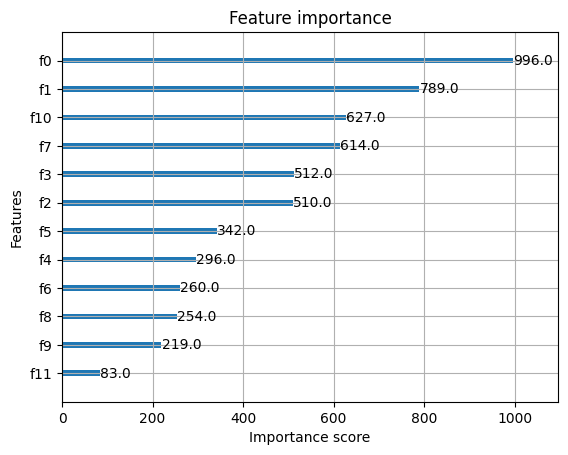

In [101]:
from xgboost import plot_importance
plot_importance(Basemodel, max_num_features = 14)
plt.show()

### feature 11,12,15 is not adding much difference to model,we can think of removing it

### final RMSE from XGBoost 

In [102]:
mse=mean_squared_error(y_pred,y_test)
rmse=np.sqrt(mse)
rmse

46574.903692724205

### predict price function

In [67]:
def predict_price(input_dict):
    df = pd.DataFrame([input_dict])
    return final_pipeline.predict(df)[0]

# Example usage
sample = {
    'longitude': -118.3,
    'latitude': 37.17,
    'housing_median_age': 22.0,
    'total_rooms': 200.0,
    'total_bedrooms': 273.0,
    'population': 151.0,
    'households': 636.0,
    'median_income': 1.75,
    'ocean_proximity': 'INLAND'
}

price = predict_price(sample)
print("Predicted house price:", price)

Predicted house price: 212841.83


## catboost regressor

In [69]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [70]:
catboost=CatBoostRegressor(iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)
catboost.fit(housing_prepared,housing_labels)

### CatBoost RMSE  & R2 score:

In [71]:
test_predictions = catboost.predict(X_test_prepared)

cat_boost_mse = mean_squared_error(y_test, test_predictions)
cat_boost_rmse = np.sqrt(cat_boost_mse)
cat_boost_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {cat_boost_rmse:.2f}")
print(f"Test R-squared: {cat_boost_r2:.2f}")

Test RMSE: 44846.55
Test R-squared: 0.85


### cross validation by In-built cv function 

In [80]:
from catboost import CatBoostRegressor, Pool, cv
import numpy as np
data_pool = Pool(housing_prepared, housing_labels)

# model parameters
params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'task_type': 'GPU',
    'verbose':0
}

# cross-validation using the catboost.cv function
cv_results = cv(
    pool=data_pool,
    params=params,
    nfold=5,
    shuffle=True,
    stratified=False, 
    early_stopping_rounds=100
)



Training on fold [0/5]
bestTest = 47529.52641
bestIteration = 1743
Training on fold [1/5]
bestTest = 47439.01149
bestIteration = 1172
Training on fold [2/5]
bestTest = 48695.91752
bestIteration = 1998
Training on fold [3/5]
bestTest = 48762.69815
bestIteration = 1966
Training on fold [4/5]
bestTest = 45932.4021
bestIteration = 1994


In [82]:
# result
print(cv_results)
print("Best CV RMSE:", cv_results["test-RMSE-mean"].min())
print("Best boosting round:", cv_results["test-RMSE-mean"].idxmin())
best_rmse = np.min(cv_results['test-RMSE-mean' and 'train-RMSE-mean'])
print(f"Best RMSE from CatBoost native CV: {best_rmse}")

      iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
0              0   226495.800377    2472.144400    226488.086088   
1              1   216492.957956    2395.990734    216458.111132   
2              2   207104.600161    2227.074900    207034.368027   
3              3   198265.761595    2118.289171    198179.190884   
4              4   189758.895838    2019.938989    189650.340062   
...          ...             ...            ...              ...   
1995        1995    47681.019213    1155.316744     40866.789892   
1996        1996    47681.557522    1154.190228     40866.424331   
1997        1997    47681.635263    1154.268348     40863.736691   
1998        1998    47681.537417    1154.093522     40863.470813   
1999        1999    47681.783237    1154.296383     40863.449888   

      train-RMSE-std  
0         653.001035  
1         592.779857  
2         609.438077  
3         590.542562  
4         532.402956  
...              ...  
1995      583.544873  

#### TEST RMSE:40K TRAIN RMSE:47K; our model is definetly not overfitting but rmse is train rmse is high

In [83]:
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    task_type='GPU'
)
cat_model.fit(housing_prepared,housing_labels)
cat_pred=cat_model.predict(X_test_prepared)
mse=mean_squared_error(y_test,cat_pred)
rmse=np.sqrt(mse)
print(rmse)

45713.28711059962


In [84]:
#model predict on some data and some labels are shown
some_pred=cat_model.predict(some_prepared_data)
some={"some_pred":some_pred,"some_labels":some_labels}
some

{'some_pred': array([ 81494.58068322, 338358.25720696,  88356.7293824 , 135019.56062293,
        230521.86600608]),
 'some_labels': 0     72100.0
 1    279600.0
 2     82700.0
 3    112500.0
 4    238300.0
 Name: median_house_value, dtype: float64}

### Optuna on catboost 

In [126]:
import optuna
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 5000),
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 20),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "eval_metric": "RMSE",
        "random_seed": 42,
        "verbose": 0
    }

    # Prepare data for CatBoost
    train_pool = Pool(housing_prepared, label=housing_labels)
    valid_pool = Pool(X_test_prepared, label=y_test)

    model = CatBoostRegressor(**params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        verbose=False,
        early_stopping_rounds=100
    )

    preds = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    return rmse

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-09-04 21:44:17,562] A new study created in memory with name: no-name-7466e21a-671c-4fd5-a868-36877f700f89
  0%|          | 0/50 [00:00<?, ?it/s]


[W 2025-09-04 21:44:17,690] Trial 0 failed with parameters: {'iterations': 4980, 'depth': 12, 'learning_rate': 0.029619667386125446, 'l2_leaf_reg': 1.599771517253303, 'random_strength': 9.358362827908861, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 45, 'subsample': 0.7327604327630407, 'leaf_estimation_iterations': 9, 'boosting_type': 'Ordered'} because of the following error: CatBoostError('catboost/private/libs/options/catboost_options.cpp:758: Ordered boosting is not supported for nonsymmetric trees.').
Traceback (most recent call last):
  File "c:\Users\Amit\anaconda3\envs\py310\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Amit\AppData\Local\Temp\ipykernel_23448\3969635843.py", line 28, in objective
    model.fit(
  File "c:\Users\Amit\anaconda3\envs\py310\lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample

CatBoostError: catboost/private/libs/options/catboost_options.cpp:758: Ordered boosting is not supported for nonsymmetric trees.

In [117]:
# Print the best hyperparameters and value
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")
print('Number of finished trials:', len(study.trials))

Best hyperparameters: {'n_estimators': 1493, 'max_depth': 7, 'learning_rate': 0.027178280411770842, 'subsample': 0.8400757156428758, 'colsample_bytree': 0.7811601333367917, 'min_child_weight': 3.4729707239161103, 'reg_alpha': 0.3536690332482689, 'reg_lambda': 1.3741020667499504}
Best RMSE: 43472.30383664973
Number of finished trials: 50


In [ ]:
import xgboost as xgb
import numpy as np

dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)

params = study.best_params.copy()
params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
})

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=3000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

TypeError: cv() got an unexpected keyword argument 'n_estimators'

#### values ain't look satisfying

## Ensemle Learning:
- stack pipeline
- stacking models
- meta model: Linear Regressor
- Bade models: XGBoost ,CatBoost

In [87]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Base models
Basemodel = XGBRegressor(random_state=42)
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# Stacking Regressor
stack = StackingRegressor(
    estimators=[
        ('xgb', Basemodel),
        ('cat', cat_model), #type: ignore
    ],
    final_estimator=LinearRegression()
)

# Full pipeline with preprocessing + stacking
full_stack_pipeline = Pipeline([
    ('full', full_pipeline),   # preprocessing pipeline
    ('stack', stack)           # stacking models
])

# Train pipeline
prepared = full_stack_pipeline.fit(housing, housing_labels)

## Stacked pipeline

In [ ]:
prepared

,steps,"[('full', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nums', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## predicting on prepared pipeline

In [89]:
y_pred=prepared.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
rmse=np.sqrt(mse)
print(f"Final RMSE:{rmse}")

Final RMSE:44189.401928103995
